In [1]:
import numpy as np
from scipy.sparse import csr_matrix, lil_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score
from sklearn.datasets import make_blobs
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import rbf_kernel
import scipy.io

In [2]:
def _euclidean_distance(X, Y, squared=False):
    XX = np.dot(X,X.T).diagonal()[:, np.newaxis]
    YY = np.dot(Y,Y.T).diagonal()[np.newaxis, :]
    distances = (-2 * np.dot(X,Y.T)) + XX + YY
    np.maximum(distances, 0, out=distances)
    if X is Y:
        np.fill_diagonal(distances, 0)
    return np.sqrt(distances, out=distances) if squared else distances

def _pairwise_kernel(X, Y = None, kernel = 'rbf', d=1):
    if Y is None:
        Y = X
    
    if kernel == 'linear':
        return np.dot(X, Y.T)
    elif kernel == 'rbf':
        dist = _euclidean_distance(X, Y, squared=True)
        # K *= -d
        return np.exp(-dist**2 / (2 * d**2))
        # return (np.exp(dist/(2*(d**2))))
    elif kernel.startswith('poly'):
        return (np.dot(X, Y.T)) ** d
    else:
        raise ValueError('Invalid kernel type.')

In [3]:
def kernel_k_means(clusters, kernel, weights, n_clusters, display=False):
  tolerance = 0.0001
  error = 0
  n = kernel.shape[0]
  center_dists = np.zeros(n)
  iter_num = 1
  
  all_errs = []
  while True:
    old_error = error
    error = 0
    
    intra_cluster = np.zeros(n_clusters)
    center_dists = np.zeros((n, n_clusters))

    for i in range(n_clusters):

      cluster_points = np.where(clusters == i)[0]
      cluster_weights = weights[cluster_points]

      intra_cluster[i] = np.dot(np.dot(kernel[cluster_points, :][:, cluster_points], 
                                       cluster_weights), cluster_weights)
      # intra_cluster[i] /= np.sum(cluster_weights) ** 2
      intra_cluster[i] /= (np.sum(cluster_weights) ** 2 + 1e-10)

      center_dists[:,i] = np.dot(kernel[:, cluster_points], cluster_weights) 
      # center_dists[:,i] = -2 * center_dists[:,i] / np.sum(cluster_weights) + intra_cluster[i]
      center_dists[:,i] = -2 * center_dists[:,i] / (np.sum(cluster_weights) + 1e-10) + intra_cluster[i]
      center_dists[:,i] += np.diag(kernel)

      center_dists[cluster_points, i] = center_dists[cluster_points, i]
      error += np.dot(cluster_weights, center_dists[cluster_points, i])
      

    min_dists, clusters = np.min(center_dists, axis=1), np.argmin(center_dists, axis=1)
    
    if display:
      print(f'Iteration {iter_num}: Error = {error}')

    # if iter_num > 1 and abs(1 - (error / old_error)) < tolerance:
    # all_errs.append(error)
    # or (iter_num > 4 and len(set(all_errs[:-4])) < 4):
    if (iter_num > 1 and abs(1 - (error / (old_error + 1e-10))) < tolerance):
      break

    iter_num += 1
      
  return clusters, error, center_dists

def CWK2M(K, n_clusters, n_views, p, init_clusters, init_weights):
  if p < 1:
    raise ValueError('p must be greater than or equal to 1')

  # if np.any(init_weights < 0) or abs(np.sum(init_weights) - 1) > 1e-15:
  #   raise ValueError('Weights must be positive and sum to unity')

  n_points = K.shape[0] // n_views

  iter_num = 1
  old_error = np.inf

  clusters = init_clusters
  weights = init_weights

  trace_per_cluster_view = [[] for _ in range(n_clusters)]
  for i in range(n_views):
    K_view = K[i*n_points:(i+1)*n_points, :]  
    for j in range(n_clusters):
      cluster_points = np.where(clusters == j)[0]
      K_cluster = K_view[cluster_points[:, None], cluster_points]
      trace_per_cluster_view[j].append(np.trace(K_cluster))
  trace_per_cluster_view = np.array(trace_per_cluster_view)
  # trace_per_view = [np.trace(K[i*n_points:(i+1)*n_points, :]) for i in range(n_views)]

  while True:
    print('--------------- CWK2M Iteration {} ---------------'.format(iter_num))

    # Update clusters
    print('Updating clusters...')

    # K_combined = np.zeros((n_points, n_points))
    # for i in range(n_views):
    #   for k in range(n_clusters):
    #     K_combined += weights[i, k]**p * K[i*n_points:(i+1)*n_points, :]

    K_combined = np.zeros((n_points, n_points))
    for i in range(n_views):
      start = i * n_points
      end = (i+1) * n_points
      K_ = K[start:end, :].copy()
      for k in range(n_clusters):
        K_combined[np.where(clusters == k)[0], :] += weights[i, k]**p * K_[np.where(clusters == k)[0], :]
        K_combined[:, np.where(clusters == k)[0]] += weights[i, k]**p * K_[:, np.where(clusters == k)[0]]

    clusters, error, _ = kernel_k_means(clusters, K_combined, np.ones(n_points), n_clusters) 
    print('Objective after updating clusters:', error)

    if len(np.unique(clusters)) < n_clusters:
      raise ValueError('Empty clusters detected')

    # Y = csr_matrix((n_points, n_clusters))
    Y = lil_matrix((n_points, n_clusters))
    for i in range(n_clusters):
      cluster_points = np.where(clusters == i)[0]
      Y[cluster_points, i] = 1 / np.sqrt(len(cluster_points))

    trace_per_cluster_view_new = []
    for i in range(n_clusters):
      cluster_traces = []
      cluster_points = np.where(clusters == i)[0]
      Y_cluster = Y[cluster_points, i]  
      for j in range(n_views):
        K_view = K[j*n_points:(j+1)*n_points, :]
        K_cluster = K_view[cluster_points[:, None], cluster_points]
        trace_cluster = np.trace(Y_cluster.T @ K_cluster @ Y_cluster)
        cluster_traces.append(trace_cluster)
      trace_per_cluster_view_new.append(cluster_traces)
    trace_per_cluster_view_new = np.array(trace_per_cluster_view_new)
    # trace_per_view_new = [np.trace(Y.T @ K[i*n_points:(i+1)*n_points, :] @ Y) for i in range(n_views)]

    trace_diff = abs(np.array([a - b for a, b in zip(trace_per_cluster_view, trace_per_cluster_view_new)])).T
    # trace_diff = np.array([a - b for a, b in zip(trace_per_view, trace_per_view_new)])

    if abs(1 - (error / old_error)) < 0.0001:
      print('CWK2M reached convergence')
      break

    old_error = error

    # Update weights 
    print('Updating weights...')

    if p != 1:
      weights = 1 / np.power(trace_diff, 1/(p-1))
      weights /= np.sum(weights)
      # print(weights)
    else:
      min_idx = np.argmin(trace_diff)
      weights = np.zeros(n_views)
      weights[min_idx] = 1

    # weights[weights < 1e-5] = 0 
    weights /= np.sum(weights)
    
    # print('Objective after updating weights:', (weights**p) @ trace_diff)
    # print('Objective after updating weights:', np.sum((weights**p) @ trace_diff.T))
    print()

    iter_num += 1

  return clusters, weights, error

In [ ]:
def global_kernel_k_means(kernel, weights, n_clusters, display=False):
  n = kernel.shape[0]
  
  best_errors = np.inf * np.ones(n_clusters)
  best_clusters = np.ones((n, n_clusters))

  # Find 1 cluster solution
  best_clusters[:,0], best_errors[0], _ = kernel_k_means(best_clusters[:,0], kernel, weights, 1, display)

  for m in range(2, n_clusters+1):

    for i in range(n):
    
      clusters = best_clusters[:,m-1].copy()
      clusters[i] = m
      
      if display:
        print(f"\nSearching for {m} clusters. Placing {m}th cluster at point {i} initially.")

      clusters, error, _ = kernel_k_means(clusters, kernel, weights, m, display)

      if display:
        print(f"Final error: {error}")

      if best_errors[m-1] > error:
        best_errors[m-1] = error
        best_clusters[:,m-1] = clusters

  if np.unique(best_clusters[:,m-1]).size < m:
    raise ValueError(f"Could not find more than {m-1} clusters")

  best_idx = np.argmin(best_errors)
  clusters = best_clusters[:, best_idx]
  error = best_errors[best_idx]

  if display:
    print(f"\nBest solution: {best_idx+1} clusters with error {error}")

  return clusters, error

: 

In [550]:
import numpy as np


def fast_global_kernel_k_means(K, dataset_weights, total_clusters, display=False):
    # Dataset size
    data_num = K.shape[0]
    
    # Store optimal clustering error for 1,2,...,total_clusters clusters
    best_error = np.zeros(total_clusters)
    
    # Store cluster assignments for optimal 1,2,...,total_clusters clusters 
    best_clusters = np.ones((data_num, total_clusters), dtype=int)
    
    # Find 1 cluster solution
    best_clusters[:,0], best_error[0], center_dist = kernel_k_means(best_clusters[:,0], K, dataset_weights, 1, display)
    
    # Find 2,...,total_clusters solutions
    for m in range(2, total_clusters):
        max_reduction = -1
        
        # Place m-th cluster at point n, calculate guaranteed error reduction
        for n in range(data_num):
            reduction = center_dist - (K[n,n] + np.diag(K) - 2*K[n,:])
            reduction[reduction < 0] = 0
            total_reduction = np.dot(dataset_weights, reduction)

            if (total_reduction > max_reduction).all():
                max_reduction = total_reduction
                index = n
        
        # Initialize m-th cluster at point with max error reduction
        cluster_elem = best_clusters[:,m-1].copy() 
        cluster_elem[index] = m
        
        if display == 'details' or display == 'nutshell':
            print('\n\nSearching for {} clusters. Initially placing {}th cluster at point {}'.format(m, m, index))
            
        # Find m cluster solution 
        best_clusters[:,m], best_error[m], center_dist = kernel_k_means(cluster_elem, K, dataset_weights, m, display)
        center_dist = center_dist[:,m-1]
        
        if display == 'details' or display == 'nutshell':
            print('Final Clustering error={}'.format(best_error[m]))
            
        if len(np.unique(best_clusters[:,m])) < m:
            raise Exception('Not able to find more than {} clusters'.format(m-1))
            
    # Solution with lowest error is best
    min_error_idx = np.argmin(best_error)
    clustering_error = best_error[min_error_idx]
    cluster_elem = best_clusters[:, min_error_idx]
    
    if display == 'details' or display == 'nutshell':
        print('++++++++++++++++++++++++++++++++++++++++++++++++++++')
        print('Best fit: {} clusters with Clustering Error={}'.format(min_error_idx+1, clustering_error))
        print('++++++++++++++++++++++++++++++++++++++++++++++++++++')
        
    return cluster_elem, clustering_error

Global Kernel K-Means initialization
End initialization

--------------- CWK2M Iteration 1 ---------------
Updating clusters...
Objective after updating clusters: 609.7826238818604
[ 11  16  36  37  46  67  68  74  83 105 108 109 113 115 123 126 130 134
 135 142 155 157 171 177 179 186 187 194 196 205 207 215 227 233 240 244
 246 271 272 293 300 301 302 303 304 305 306 307 308 309 310 311 312 313
 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331
 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349
 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367
 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385
 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403
 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421
 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439
 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457
 458 459 460 461

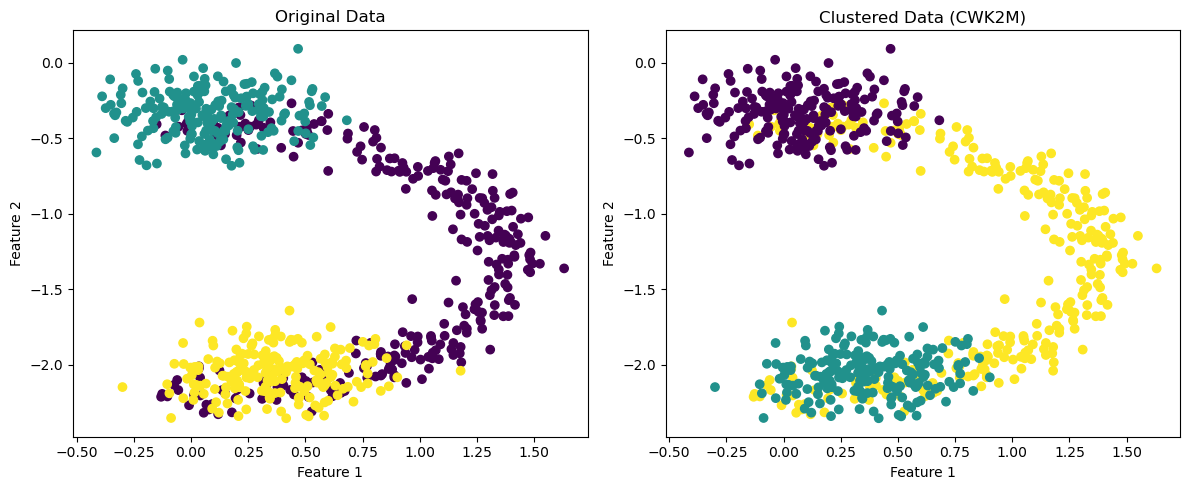

In [551]:
n_clusters = 3
data = scipy.io.loadmat('datasets/synthetic_data.mat')

X1 = data["View_1"]
X2 = data["View_2"]
X = [X1, X2]
y = data["Ground_truth"]

# K = np.array(scipy.io.loadmat('datasets/synthetic_data_kernel.mat')['K'])
K = np.vstack([_pairwise_kernel(X1, kernel="rbf", d=0.2), _pairwise_kernel(X2, kernel="rbf", d=0.2)])

# Run CWK2M
n_views = 2
p = 1.5
init_weights = np.full((n_views, n_clusters), 1 / n_views)
n_points = K.shape[0] // n_views
init_clusters = np.random.randint(0, n_clusters, n_points)

# Compute composite kernel 
K_combined = np.zeros((n_points, n_points))
for i in range(n_views):
  start = i * n_points
  end = (i+1) * n_points
  K_ = K[start:end, :]
  for k in range(n_clusters):
    K_combined[np.where(init_clusters == k)[0], :] += init_weights[i, k]**p * K_[np.where(init_clusters == k)[0], :]
    K_combined[:, np.where(init_clusters == k)[0]] += init_weights[i, k]**p * K_[:, np.where(init_clusters == k)[0]]
    
# Initialize with Global K-Means
print('Global Kernel K-Means initialization')
# init_clusters = global_kernel_k_means(K_combined, np.ones(n_points), n_clusters)
print('End initialization\n')

cluster_labels, weights, error = CWK2M(K, n_clusters, n_views, p, init_clusters, init_weights)

# Plot the original data and the clustered data
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X2[:, 0], X2[:, 1], c=y, cmap='viridis')
plt.title('Original Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.subplot(1, 2, 2)
plt.scatter(X2[:, 0], X2[:, 1], c=cluster_labels, cmap='viridis')
plt.title('Clustered Data (CWK2M)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()

In [552]:
from sklearn.metrics import normalized_mutual_info_score

# Calculate NMI
nmi_score = normalized_mutual_info_score(cluster_labels, y.flatten())
print("Normalized Mutual Information (NMI):", np.round(nmi_score * 100, 2), "%")

Normalized Mutual Information (NMI): 97.29 %


### Multiple Features dataset

In [605]:

data = scipy.io.loadmat('datasets/handwritten.mat')
X_ = data['X'].flatten()
print(X[3].shape)

(2000, 240)


In [669]:
import pandas as pd

# V1 = pd.read_csv('datasets/HW/mfeat-fou', header=None, delimiter="\\s+").to_numpy(dtype=np.float64)
# V2 = pd.read_csv('datasets/HW/mfeat-fac', header=None, delimiter="\\s+").to_numpy(dtype=np.float64)
# V3 = pd.read_csv('datasets/HW/mfeat-kar', header=None, delimiter="\\s+").to_numpy(dtype=np.float64)
# V4 = pd.read_csv('datasets/HW/mfeat-pix', header=None, delimiter="\\s+").to_numpy(dtype=np.float64)
# X = [V1, V2, V3, V4]
# y = np.vstack([np.full(200, i) for i in range(10)]).flatten()

data = scipy.io.loadmat('datasets/handwritten.mat')
X_ = data['X'].flatten()
X = [X_[0].astype(np.float64), X_[1].astype(np.float64), X_[2].astype(np.float64), X_[3].astype(np.float64)]
y = data['Y'].flatten()

n_clusters = 10
K = np.vstack([_pairwise_kernel(v, kernel="rbf", d=0.4)/np.mean(_pairwise_kernel(v, kernel="rbf", d=0.4)) for v in X])

# Run CWK2M
n_views = len(X)
p = (10**0.8)
init_weights = np.full((n_views, n_clusters), 1 / n_views)
# init_weights = np.full(n_views, 1/n_views)

n_points = K.shape[0] // n_views
# Compute composite kernel 
K_combined = np.zeros((n_points, n_points))
for i in range(n_views):
  start = i * n_points
  end = (i+1) * n_points
  K_ = K[start:end, :]
  for k in range(n_clusters):
    K_combined[np.where(init_clusters == k)[0], :] += init_weights[i, k]**p * K_[np.where(init_clusters == k)[0], :]
    K_combined[:, np.where(init_clusters == k)[0]] += init_weights[i, k]**p * K_[:, np.where(init_clusters == k)[0]]


# Initialize with Global K-Means
print('Global Kernel K-Means initialization')
# init_clusters = global_kernel_k_means(K_combined, np.ones(n_points), n_clusters)
init_clusters = np.random.randint(0, n_clusters, n_points)
# init_clusters = np.load('multi_features_init.npy')
print('End initialization\n')

cluster_labels, weights, error = CWK2M(K, n_clusters, n_views, p, init_clusters, init_weights)

Global Kernel K-Means initialization
End initialization

--------------- CWK2M Iteration 1 ---------------
Updating clusters...
Objective after updating clusters: 3655.2498541294235
Updating weights...

--------------- CWK2M Iteration 2 ---------------
Updating clusters...
Objective after updating clusters: 0.00030325149929123795
Updating weights...

--------------- CWK2M Iteration 3 ---------------
Updating clusters...
Objective after updating clusters: 0.0002973844722373407
Updating weights...

--------------- CWK2M Iteration 4 ---------------
Updating clusters...
Objective after updating clusters: 0.0002972895625267996
Updating weights...

--------------- CWK2M Iteration 5 ---------------
Updating clusters...
Objective after updating clusters: 0.0002972125634606005
Updating weights...

--------------- CWK2M Iteration 6 ---------------
Updating clusters...
Objective after updating clusters: 0.0002972125634606005
CWK2M reached convergence


In [671]:
# Calculate NMI
nmi_score = normalized_mutual_info_score(cluster_labels, y.flatten())
print("Normalized Mutual Information (NMI):", np.round(nmi_score * 100, 2), "%")

Normalized Mutual Information (NMI): 61.29 %


In [612]:
accuracy = 0
for i in range(10):
    lbls = cluster_labels[200*i:200*i+200]
    # print(np.max(np.bincount((lbls))), np.argmax(np.bincount((lbls))))
    acc = (np.max(np.bincount((lbls))) * 100/200)
    accuracy = accuracy + acc 
    print(f'{i}: {acc}%')

print(accuracy/10)

0: 61.0%
1: 45.0%
2: 71.0%
3: 92.5%
4: 68.0%
5: 94.0%
6: 36.0%
7: 75.0%
8: 94.5%
9: 38.0%
67.5


(2000, 2)


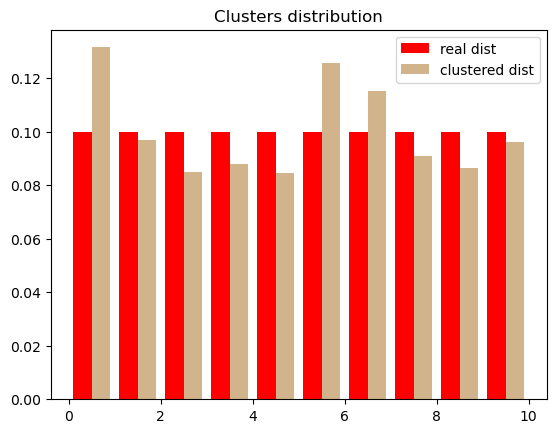

In [ ]:
x = np.array([y.flatten(), cluster_labels]).T
n_bins = 10
colors = ['red', 'tan']
bar_lbls = ['real dist', 'clustered dist']
bins = np.arange(0, 11)
_ = plt.hist(x, bins, density=True, histtype='bar', color=colors, label=bar_lbls)  # arguments are passed to np.histogram
plt.title("Clusters distribution")
plt.legend(prop={'size': 10})
plt.show()

In [600]:
data = scipy.io.loadmat('datasets/handwritten.mat')
X = data['X'].flatten()

print(X[1].shape)

(2000, 76)


### MSRC-v1

In [15]:
data = scipy.io.loadmat('datasets/MSRC-v1.mat')

X = data["X"].flatten()
# X = np.array([v.astype(np.float64) or v in X])
X = [np.array(v, dtype=np.float64) for v in X]
y = data["Y"]

n_clusters = 7
K = np.vstack([_pairwise_kernel(v, kernel="rbf", d=0.5)/np.mean(_pairwise_kernel(v, kernel="rbf", d=0.5)) for v in X])

# Run CWK2M
n_points = K.shape[0] // n_views
n_views = len(X)
p = (10**0.7)
init_weights = np.full((n_views, n_clusters), 1 / n_views)
init_clusters = np.random.randint(0, n_clusters, n_points)

# Compute composite kernel 
K_combined = np.zeros((n_points, n_points))
for i in range(n_views):
  start = i * n_points
  end = (i+1) * n_points
  K_ = K[start:end, :]
  for k in range(n_clusters):
    K_combined[np.where(init_clusters == k)[0], :] += init_weights[i, k]**p * K_[np.where(init_clusters == k)[0], :]
    K_combined[:, np.where(init_clusters == k)[0]] += init_weights[i, k]**p * K_[:, np.where(init_clusters == k)[0]]

# best=0
# for i in range(50):
#   # Initialize with Global K-Means
#   print('Global Kernel K-Means initialization')
#   # init_clusters = global_kernel_k_means(K_combined, np.ones(n_points), n_clusters)
#   init_clusters = np.random.randint(0, n_clusters, n_points)
#   # init_clusters = np.load('multi_features_init.npy')
#   print('End initialization\n')

#   cluster_labels, weights, error = CWK2M(K, n_clusters, n_views, p, init_clusters, init_weights)
#   nmi_score = normalized_mutual_info_score(cluster_labels, y.flatten())

#   if(nmi_score>best):
#     best=nmi_score
#     np.save('msrcv_init.npy', init_clusters)


# Initialize with Global K-Means
print('Global Kernel K-Means initialization')
# init_clusters = global_kernel_k_means(K_combined, np.ones(n_points), n_clusters)
print('End initialization\n')
init_clusters = np.load('msrcv_init.npy')

cluster_labels, weights, error = CWK2M(K, n_clusters, n_views, p, init_clusters, init_weights)

Global Kernel K-Means initialization
End initialization

--------------- CWK2M Iteration 1 ---------------
Updating clusters...
Objective after updating clusters: 246.51992816650755
Updating weights...

--------------- CWK2M Iteration 2 ---------------
Updating clusters...
Objective after updating clusters: 0.00293391013022568
Updating weights...

--------------- CWK2M Iteration 3 ---------------
Updating clusters...
Objective after updating clusters: 0.002961056401244603
Updating weights...

--------------- CWK2M Iteration 4 ---------------
Updating clusters...
Objective after updating clusters: 0.002870709413860807
Updating weights...

--------------- CWK2M Iteration 5 ---------------
Updating clusters...
Objective after updating clusters: 0.0028922901745135755
Updating weights...

--------------- CWK2M Iteration 6 ---------------
Updating clusters...
Objective after updating clusters: 0.002869123557906748
Updating weights...

--------------- CWK2M Iteration 7 ---------------
Updatin

In [16]:
# Calculate NMI
nmi_score = normalized_mutual_info_score(cluster_labels, y.flatten())
print("Normalized Mutual Information (NMI):", np.round(nmi_score * 100, 2), "%")

Normalized Mutual Information (NMI): 68.48 %


### Caltech101-7

In [34]:
data = scipy.io.loadmat('datasets/Caltech101-7.mat')
X_ = data['X'].flatten()
X = [X_[0].astype(np.float64), X_[1].astype(np.float64), X_[2].astype(np.float64), X_[3].astype(np.float64)]
y = data['Y'].flatten()

n_clusters = len(np.unique(y))
K = np.vstack([_pairwise_kernel(v, kernel="poly", d=0.5)/np.mean(_pairwise_kernel(v, kernel="poly", d=0.5)) for v in X])

# Run CWK2M
n_points = K.shape[0] // n_views
n_views = len(X)
p = (10**0.9)
init_weights = np.full((n_views, n_clusters), 1 / n_views)
init_clusters = np.random.randint(0, n_clusters, n_points)

# Compute composite kernel 
K_combined = np.zeros((n_points, n_points))
for i in range(n_views):
  start = i * n_points
  end = (i+1) * n_points
  K_ = K[start:end, :]
  for k in range(n_clusters):
    K_combined[np.where(init_clusters == k)[0], :] += init_weights[i, k]**p * K_[np.where(init_clusters == k)[0], :]
    K_combined[:, np.where(init_clusters == k)[0]] += init_weights[i, k]**p * K_[:, np.where(init_clusters == k)[0]]

# best=0
# for i in range(50):
#   # Initialize with Global K-Means
#   print('Global Kernel K-Means initialization')
#   # init_clusters = global_kernel_k_means(K_combined, np.ones(n_points), n_clusters)
#   init_clusters = np.random.randint(0, n_clusters, n_points)
#   # init_clusters = np.load('multi_features_init.npy')
#   print('End initialization\n')

#   cluster_labels, weights, error = CWK2M(K, n_clusters, n_views, p, init_clusters, init_weights)
#   nmi_score = normalized_mutual_info_score(cluster_labels, y.flatten())

#   if(nmi_score>best):
#     best=nmi_score
#     np.save('caltech101_init.npy', init_clusters)


# Initialize with Global K-Means
print('Global Kernel K-Means initialization')
# init_clusters = global_kernel_k_means(K_combined, np.ones(n_points), n_clusters)
print('End initialization\n')
# init_clusters = np.load('caltech101_init.npy')
init_clusters = np.random.randint(0, n_clusters, n_points)

cluster_labels, weights, error = CWK2M(K, n_clusters, n_views, p, init_clusters, init_weights)

Global Kernel K-Means initialization
End initialization

--------------- CWK2M Iteration 1 ---------------
Updating clusters...
Objective after updating clusters: 1.7835927105530458
Updating weights...

--------------- CWK2M Iteration 2 ---------------
Updating clusters...


KeyboardInterrupt: 

In [696]:
# Calculate NMI
nmi_score = normalized_mutual_info_score(cluster_labels, y.flatten())
print("Normalized Mutual Information (NMI):", np.round(nmi_score * 100, 2), "%")

Normalized Mutual Information (NMI): 0.69 %


### Reuters

In [5]:
data = scipy.io.loadmat('datasets/reuters.mat')
X_ = data['X'].flatten()
X = [x.astype(np.float64) for x in X_]
y = data['Y'].flatten()

n_clusters = len(np.unique(y))
K = np.vstack([_pairwise_kernel(v, kernel="rbf", d=0.5)/np.mean(_pairwise_kernel(v, kernel="rbf", d=0.5)) for v in X])

# Run CWK2M
n_points = K.shape[0] // n_views
n_views = len(X)
p = (10**0.9)
init_weights = np.full((n_views, n_clusters), 1 / n_views)
init_clusters = np.random.randint(0, n_clusters, n_points)

# Compute composite kernel 
# K_combined = np.zeros((n_points, n_points))
# for i in range(n_views):
#   start = i * n_points
#   end = (i+1) * n_points
#   K_ = K[start:end, :]
#   for k in range(n_clusters):
#     K_combined[np.where(init_clusters == k)[0], :] += init_weights[i, k]**p * K_[np.where(init_clusters == k)[0], :]
#     K_combined[:, np.where(init_clusters == k)[0]] += init_weights[i, k]**p * K_[:, np.where(init_clusters == k)[0]]

# best=0
# for i in range(50):
#   # Initialize with Global K-Means
#   print('Global Kernel K-Means initialization')
#   # init_clusters = global_kernel_k_means(K_combined, np.ones(n_points), n_clusters)
#   init_clusters = np.random.randint(0, n_clusters, n_points)
#   # init_clusters = np.load('multi_features_init.npy')
#   print('End initialization\n')

#   cluster_labels, weights, error = CWK2M(K, n_clusters, n_views, p, init_clusters, init_weights)
#   nmi_score = normalized_mutual_info_score(cluster_labels, y.flatten())

#   if(nmi_score>best):
#     best=nmi_score
#     np.save('caltech101_init.npy', init_clusters)


# Initialize with Global K-Means
print('Global Kernel K-Means initialization')
# init_clusters = global_kernel_k_means(K_combined, np.ones(n_points), n_clusters)
print('End initialization\n')
# init_clusters = np.load('caltech101_init.npy')
init_clusters = np.random.randint(0, n_clusters, n_points)

cluster_labels, weights, error = CWK2M(K, n_clusters, n_views, p, init_clusters, init_weights)

In [ ]:
# Calculate NMI
nmi_score = normalized_mutual_info_score(cluster_labels, y.flatten())
print("Normalized Mutual Information (NMI):", np.round(nmi_score * 100, 2), "%")